In [2]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random as rd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy import stats


In [ ]:
# Project I
# Task I - Data Exploration and Pre-processing
# KV - Pre-processing

# Basic Definitions
dsList = ["KV-PeriodicLoad", "KV-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
target = "ReadsAvg"

# Main
for ds in dsList:
    #Read X, Y raw files
    xRaw = pd.read_csv(dir + ds + "/X.csv", 
                       usecols = lambda column : column not in ["TimeStamp"])
    #print("xRaw:")
    #print(xRaw)

    yRaw = pd.read_csv(dir + ds + "/Y.csv", 
                       usecols = [target])
    #print("yRaw:")
    #print(yRaw)    

    # Removing outliers
    z_scores = stats.zscore(yRaw)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    xRawLimited = xRaw[filtered_entries]
    #print("xRawLimited:")
    #print(xRawLimited)
    yRawLimited = yRaw[filtered_entries]
    #print("yRawLimited:")
    #print(yRawLimited)

    # Pre-Processing
    xRawNormL2 = preprocessing.normalize(xRawLimited, norm='l2')
    #print("xRawNormL2:")
    #print(xRawNormL2)

    xRawStandard = preprocessing.scale(xRawLimited)
    #print("xRawStandard:")
    #print(xRawStandard)

    xRawRestriction = preprocessing.MinMaxScaler().fit_transform(xRawLimited)
    #print("xRawRestriction:")
    #print(xRawRestriction)

    #Create dataframes and save files
    xLimited = pd.DataFrame(xRawLimited)
    #print("xLimited:")
    #print(xLimited)
    xLimited.to_csv(dir + ds + "/XLimited.csv")

    yLimited = pd.DataFrame(yRawLimited)
    #print("yLimited:")
    #print(yLimited)
    yLimited.to_csv(dir + ds + "/YLimited.csv")

    xNormL2 = pd.DataFrame(xRawNormL2)
    #print("xNormL2:")
    #print(xNormL2)
    xNormL2.to_csv(dir + ds + "/XNormL2.csv")

    xStandard = pd.DataFrame(xRawStandard)
    #print("xStandard:")
    #print(xStandard)
    xStandard.to_csv(dir + ds + "/XStandard.csv")

    xRestricted = pd.DataFrame(xRawRestriction)
    #print("xRestricted:")
    #print(xRestricted)
    xRestricted.to_csv(dir + ds + "/XRestricted.csv")


In [ ]:
# Project I
# Task I - Data Exploration and Pre-processing
# KV - Feature Selection

# Basic Definitions
dsList = ["KV-PeriodicLoad", "KV-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
target = "ReadsAvg"
k=16

# Main
for ds in dsList:
    print("Dataset: " + ds)

    #Read X, Y raw files
    xRaw = pd.read_csv(dir + ds + "/XRestricted.csv", index_col=0, header=0)
    #print("xRaw:")
    #print(xRaw)

    yRaw = pd.read_csv(dir + ds + "/YLimited.csv", usecols = [target])
    #print("yRaw:")
    #print(yRaw) 

    #Create a k-feature selector
    selector = SelectKBest(f_classif, k) 

    #Create a RandomForest Regressor 
    regr = RandomForestRegressor(max_depth=50, n_estimators=150, n_jobs=4)

    #Create (X,Y) train and test datasets
    xTrain, xTest, yTrain, yTest = train_test_split(xRaw, yRaw[target], test_size=0.3)

    #Do k-feature selection
    xTrainSelected = selector.fit_transform(xTrain, yTrain)
    xTestSelected = selector.transform(xTest)
    xRawSelected  = np.concatenate((xTrainSelected, xTestSelected))

    xSelected = pd.DataFrame(xRawSelected)
    #print(xSelected)

    xSelected.to_csv(dir + ds + "/XSelected.csv")

    #idxsSelected = selector.get_support(indices=True)
    #print(idxsSelected)


In [ ]:
# Project II
# Task I - Offline learning on small-size training set
# KV - Baseline Evaluation

# Basic Definitions
dsList = ["KV-PeriodicLoad", "KV-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "ReadsAvg"
iterations = 100

# Main
for ds in dsList:
    print("Dataset: " + ds)

    #Read X, Y raw files
    xRaw = pd.read_csv(dir + ds + "/XSelected.csv", index_col=0, header=0)
    #print("xRaw:")
    #print(xRaw)

    yRaw = pd.read_csv(dir + ds + "/YLimited.csv", usecols = [target])
    #print("yRaw:")
    #print(yRaw) 

    results = pd.DataFrame(columns=['iteration', 'nmae'])
      
    for iter in range (1, iterations+1):
        print("Iteration: " + str(iter))

        # Create a RandomForest Regressor
        regr = RandomForestRegressor(max_depth=10, n_estimators=30, n_jobs=4, random_state=13)

        # Create Training and Test Datasets
        xTrain, xTest, yTrain, yTest = train_test_split(xRaw, yRaw[target], test_size=0.7)

        # Build the Model
        regr.fit(xTrain, yTrain)

        # Do Predictions
        yPredicted = regr.predict(xTest)

        # Calculate NMAE
        nmae  = (abs(yPredicted - yTest).mean())/yTest.mean()
        #print("NMAE: " + str(nmae))

        nr = results.append({'iteration': iter, 'nmae': nmae}, ignore_index=True)
        results = pd.concat([nr])

    results.to_csv(outdir + "p2t1-baseline-" + ds + ".csv")
    #print(results)


In [ ]:
# Project II
# Task I - Offline learning on small-size training set
# KV - Baseline Statistics

# Basic Definitions
dsList = ["KV-PeriodicLoad", "KV-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "ReadsAvg"

for ds in dsList:
    print("Dataset: " + ds)

    results = pd.read_csv(outdir + "p2t1-baseline-" + ds + ".csv", index_col=0)
    print(results)

    graphResults = pd.DataFrame(columns=['avg', 'stddev'])

    nr = graphResults.append({'avg': results['nmae'].mean(), 
                              'stddev': results['nmae'].std()}, ignore_index=True)
    graphResults = pd.concat([nr])
    
    print(graphResults)
    graphResults.to_csv(outdir + "p2t1-baseline-stats-" + ds + ".csv")


In [ ]:
# Project II
# Task I - Offline learning on small-size training set
# KV - Offline Small-Size

# Basic Definitions
dsList = ["KV-PeriodicLoad", "KV-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "ReadsAvg"
cacheSizeList = [32, 128, 512, 2048]
testSize = 1000
iterations = 100

# Main
for ds in dsList:
    print("Dataset: " + ds)

    #Read X, Y raw files
    xRaw = pd.read_csv(dir + ds + "/XSelected.csv", index_col=0, header=0)
    #print("xRaw:")
    #print(xRaw)

    yRaw = pd.read_csv(dir + ds + "/YLimited.csv", usecols = [target])
    #print("yRaw:")
    #print(yRaw) 

    results = pd.DataFrame(columns=['cachesize', 'iteration', 'nmae'])

    for cacheSize in cacheSizeList:
        print("Cache Size: " + str(cacheSize))
       
        for iter in range (1, iterations+1):
            print("Iteration: " + str(iter))

            # Create a RandomForest Regressor
            regr = RandomForestRegressor(max_depth=10, n_estimators=30, n_jobs=4, random_state=13)


            xTrain, xTest, yTrain, yTest = train_test_split(xRaw, yRaw[target], 
                                                            test_size=testSize, 
                                                            train_size=cacheSize)
            #print("xTrain:")
            #print(xTrain)
            #print("xTest:")
            #print(xTest)
            #print("yTrain:")
            #print(yTrain)
            #print("yTest:")
            #print(yTest)

            # Build the Model
            regr.fit(xTrain, yTrain)

            # Do Predictions
            yPredicted = regr.predict(xTest)

            # Calculate NMAE
            nmae  = (abs(yPredicted - yTest).mean())/yTest.mean()
            #print("NMAE: " + str(nmae))

            nr = results.append({'cachesize': cacheSize, 'iteration': iter, 'nmae': nmae},  
                                ignore_index=True)
            results = pd.concat([nr])

    results.to_csv(outdir + "p2t1-offline-" + ds + ".csv")
    print(results)


In [ ]:
# Project II
# Task I - Offline learning on small-size training set
# KV - Statistics

# Basic Definitions
dsList = ["KV-PeriodicLoad", "KV-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "ReadsAvg"
cacheSizeList = [32, 128, 512, 2048]

for ds in dsList:
    print("Dataset: " + ds)

    results = pd.read_csv(outdir + "p2t1-offline-" + ds + ".csv", index_col=0)
    print(results)

    graphResults = pd.DataFrame(columns=['cachesize', 'avg', 'stddev'])

    for cacheSize in cacheSizeList:
        print("Cache Size: " + str(cacheSize))

        cacheResults = results[results['cachesize']==cacheSize]
        #print(cacheResults)

        nr = graphResults.append({'cachesize': cacheSize, 'avg': cacheResults['nmae'].mean(), 
                                  'stddev': cacheResults['nmae'].std()}, ignore_index=True)
        graphResults = pd.concat([nr])
    
    print(graphResults)
    graphResults.to_csv(outdir + "p2t1-offline-stats-" + ds + ".csv")


In [ ]:
# Project II
# Task I - Offline learning on small-size training set
# KV - Figure

# Basic Definitions
font = {'size'   : 14}
plt.rc('font', **font)
outdir = "~/Documentos/kth/project/results/"
cacheSizeList = [32, 128, 512, 2048]

dfKVPeriodicLoad = pd.read_csv(outdir + "p2t1-offline-stats-KV-PeriodicLoad.csv", index_col=None, 
                               usecols = ["avg", "stddev"], header=0)    
print("KV-PeriodicLoad:")
print(dfKVPeriodicLoad)

dfKVFlashcrowdLoad = pd.read_csv(outdir + "p2t1-offline-stats-KV-FlashcrowdLoad.csv", index_col=None, 
                                 usecols = ["avg", "stddev"], header=0)   
print("KV-FlashcrowdLoad:")
print(dfKVFlashcrowdLoad)

plt.title("Prediction Error (NMAE)")
#plt.suptitle(hostname)
    
#plt.ylim((0.03, 0.05))
#plt.yticks([0.03, 0.035, 0.04, 0.045, 0.05], [0.03, 0.035, 0.04, 0.045, 0.05])

x  = np.array(cacheSizeList)

yKVPL = np.array(dfKVPeriodicLoad["avg"])
yKVFL = np.array(dfKVFlashcrowdLoad["avg"])

errorKVPL = np.array(dfKVPeriodicLoad["stddev"])
errorKVFL = np.array(dfKVFlashcrowdLoad["stddev"])

#plt.fill_between(x, yRS - errorRS, yRS + errorRS, alpha=0.4, color = "blue")
#plt.fill_between(x, yRRFS - errorRRFS, yRRFS + errorRRFS, alpha=0.4, color = "orange")

plt.errorbar(x, yKVPL, yerr=errorKVPL, marker='x', label='KV-PeriodicLoad', color = "blue")
plt.errorbar(x, yKVFL, yerr=errorKVFL, marker='o', label='KV-FlashcrowdLoad', color = "orange")

#plt.plot(x, yRS, marker='x', label='RS', color = "blue")
#plt.plot(x, yRRFS, marker='o', label='RR-SS', color = "orange")

plt.xlabel("Cache Size")
plt.xscale('log', basex=2)
plt.xticks(x, x, rotation=60)

plt.ylabel("NMAE")
plt.legend(loc='best')
#plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.tight_layout()
filename = "results/p2t1-offline-KV.png"
#print(filename)
plt.savefig(filename)
plt.show()
plt.close()


In [ ]:
# Project II
# Task I - Offline learning on small-size training set
# KV
# RR-SS

# Basic Definitions
dsList = ["KV-PeriodicLoad", "KV-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "ReadsAvg"
cacheSizeList = [32, 128, 512, 2048]
seqSize = 5000
testSize = 1000
iterations = 100

# Main
for ds in dsList:
    print("Dataset: " + ds)

    #Read X, Y raw files
    xRaw = pd.read_csv(dir + ds + "/XSelected.csv", index_col=0, header=0)
    #print("xRaw:")
    #print(xRaw)

    yRaw = pd.read_csv(dir + ds + "/YLimited.csv", usecols = [target])
    #print("yRaw:")
    #print(yRaw) 

    # Total size of the dataset
    dsSize = len(xRaw.index)

    results = pd.DataFrame(columns=['cachesize', 'iteration', 'nmae'])

    for iter in range(1, iterations+1):
        print("Iteration: " + str(iter))

        for cacheSize in cacheSizeList:
            print("Cache Size: " + str(cacheSize))

            init = rd.randint(0, dsSize//2)
            #print("Init: ")
            #print(init)

            # Define (X,Y) cache of size cacheSize
            cacheX = xRaw.iloc[init:(init+cacheSize), 0:]
            #print("cacheX:")
            #print(cacheX)
            
            cacheY = yRaw.iloc[init:(init+cacheSize), 0:2]
            #print("cacheY:")
            #print(cacheY)

            # Rebuild indexes
            cacheX = cacheX.reset_index(drop=True)
            cacheY = cacheY.reset_index(drop=True)
            #print("cacheX:")
            #print(cacheX)

            # Define a sample vector with the average of all columns in the cache
            cacheAvgSample = pd.DataFrame(cacheX.mean()).transpose()
            #print("cacheAvgSample:")
            #print(cacheAvgSample)

            # Define a vector with the redundancy values between all samples in the cache
            # and the sample vector with the average of all columns
            cacheRedundancyValues = cosine_similarity(cacheX, cacheAvgSample)
            #print("cacheRedundancyValues:")
            #print(cacheRedundancyValues)

            # Define a vector with the relevance values between all samples in the cache
            # and the sample vector with the average of all columns
            cacheRelevanceValues = euclidean_distances(cacheX, cacheAvgSample)
            #print("cacheRelevanceValues:")
            #print(cacheRelevanceValues)

            # Define a vector with the rank between all samples in the cache
            # and the sample vector with the average of all columns
            cacheRankValues = cacheRelevanceValues/cacheRedundancyValues
            #print("cacheRankValues:")
            #print(pd.DataFrame(cacheRankValues).sort_values(by=0))

            # Define the mean value of the rank vector
            cacheRankAvg = pd.DataFrame(cacheRankValues).mean()
            #print("cacheRankMean:")
            #print(cacheRankMean[0])

            # Build a RF regressor and Fit the model 
            regr = RandomForestRegressor(max_depth=10, n_estimators=30, n_jobs=4, random_state=13)
            #print ("Build Model Ok!")

            for index in range(init+cacheSize, init+cacheSize+seqSize):
                sampleX = xRaw.iloc[index:(index + 1), 0:]
                sampleY = yRaw.iloc[index:(index + 1), 0:2]
                #print("sampleX #" + str(index))
                #print(sampleX)

                sampleRedundancy = cosine_similarity(cacheAvgSample, sampleX)
                #print(sampleRedundancy)

                sampleRelevance = euclidean_distances(cacheAvgSample, sampleX)
                #print(sampleRelevance)

                sampleRank = sampleRelevance/sampleRedundancy
                #print("sampleRank)

                if (sampleRank[0][0] > cacheRankAvg[0]):
                #print("Sample#" + str(index) + ": Insert")

                    # Find the index of the sample with the minimum rank in the cache
                    idxMinCache = pd.DataFrame(cacheRankValues).idxmin().values[0]
                    #print(idxMinCache)

                    # Remove idxMinCache sample from the cache
                    #print(cacheX.iloc[idxMinCache])
                    cacheX = cacheX.drop([idxMinCache])
                    cacheY = cacheY.drop([idxMinCache])

                    # Rebuild indexes
                    #cacheX = cacheX.reset_index(drop=True)
                    #cacheY = cacheY.reset_index(drop=True)

                    # Insert the new sample in the cache      
                    cacheX = pd.concat([sampleX, cacheX], ignore_index=True, sort=True)
                    cacheY = pd.concat([sampleY, cacheY], ignore_index=True, sort=True)
                            
                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)

                    # Update the sample vector with the average of all columns in the cache
                    cacheAvgSample = pd.DataFrame(cacheX.mean()).transpose()
                    #print(cacheAvgSample)

                    # Update the vector with the redundancy values between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRedundancyValues = cosine_similarity(cacheX, cacheAvgSample)
                    #print(cacheRedundancyValues)

                    # Update the vector with the relevance values between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRelevanceValues = euclidean_distances(cacheX, cacheAvgSample)
                    #print(cacheRelevanceValues)

                    # Update the vector with the rank between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRankValues = cacheRelevanceValues/cacheRedundancyValues
                    #print(cacheRankValues)
                    #print(pd.DataFrame(cacheRankValues).sort_values(by=0))

                    # Update the average value of the rank vector
                    cacheRankAvg = pd.DataFrame(cacheRankValues).mean()
                    #print(cacheRankMedian)
            
            # Build the Model
            regr.fit(cacheX, cacheY)

            #print("TestIndex: " + str(index))
            
            # Defining (X,Y) test dataset for next predictions
            testX = xRaw.iloc[index:(index+testSize), 0:]
            testY = yRaw.iloc[index:(index+testSize), 0:2]
            #print("testX:")
            #print(testX)
            #print("testY:")
            #print(testY)

            # Do Predictions
            predictedY = regr.predict(testX)

            #print("predictedY:")
            #print(predictedY)
            #print("testY:")
            #print(testY.values.ravel())

            # Calculate NMAE
            nmae  = (abs(predictedY - testY.values.ravel()).mean())/(testY.values.ravel().mean())
            #print("NMAE: " + str(nmae))

            nr = results.append({'cachesize': cacheSize, 'iteration': iter, 'nmae': nmae},  
                                    ignore_index=True)
            results = pd.concat([nr])
    results.to_csv(outdir + "p2t1-rrss-" + ds + ".csv")


In [ ]:
# Project II
# Task I - Offline learning on small-size training set
# KV - Statistics

# Basic Definitions
dsList = ["KV-PeriodicLoad", "KV-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "ReadsAvg"
cacheSizeList = [32, 128, 512, 2048]

for ds in dsList:
    print("Dataset: " + ds)

    results = pd.read_csv(outdir + "p2t1-rrss-" + ds + ".csv", index_col=0)
    print(results)

    graphResults = pd.DataFrame(columns=['cachesize', 'avg', 'stddev'])

    for cacheSize in cacheSizeList:
        print("Cache Size: " + str(cacheSize))

        cacheResults = results[results['cachesize']==cacheSize]
        #print(cacheResults)

        nr = graphResults.append({'cachesize': cacheSize, 'avg': cacheResults['nmae'].mean(), 
                                  'stddev': cacheResults['nmae'].std()}, ignore_index=True)
        graphResults = pd.concat([nr])
    
    print(graphResults)
    graphResults.to_csv(outdir + "p2t1-rrss-stats-" + ds + ".csv")
    

In [ ]:
# Project II
# Task I - Offline learning on small-size training set
# KV - Figures

# Basic Definitions
font = {'size'   : 14}
plt.rc('font', **font)
outdir = "~/Documentos/kth/project/results/"
cacheSizeList = [32, 128, 512, 2048]

dfVoDPeriodicLoad = pd.read_csv(outdir + "p2t1-rrss-stats-KV-PeriodicLoad.csv", index_col=None, 
                                usecols = ["avg", "stddev"], header=0)    
print("KV-PeriodicLoad:")
print(dfVoDPeriodicLoad)

dfVoDFlashcrowdLoad = pd.read_csv(outdir + "p2t1-rrss-stats-KV-FlashcrowdLoad.csv", index_col=None, 
                                  usecols = ["avg", "stddev"], header=0)   
print("KV-FlashcrowdLoad:")
print(dfVoDFlashcrowdLoad)

plt.title("Prediction Error (NMAE)")
#plt.suptitle(hostname)
    
#plt.ylim((0.03, 0.05))
#plt.yticks([0.03, 0.035, 0.04, 0.045, 0.05], [0.03, 0.035, 0.04, 0.045, 0.05])

x  = np.array(cacheSizeList)

yVoDPL = np.array(dfVoDPeriodicLoad["avg"])
yVoDFL = np.array(dfVoDFlashcrowdLoad["avg"])

errorVoDPL = np.array(dfVoDPeriodicLoad["stddev"])
errorVoDFL = np.array(dfVoDFlashcrowdLoad["stddev"])

#plt.fill_between(x, yRS - errorRS, yRS + errorRS, alpha=0.4, color = "blue")
#plt.fill_between(x, yRRFS - errorRRFS, yRRFS + errorRRFS, alpha=0.4, color = "orange")

plt.errorbar(x, yVoDPL, yerr=errorVoDPL, marker='x', label='KV-PeriodicLoad', color = "blue")
plt.errorbar(x, yVoDFL, yerr=errorVoDFL, marker='o', label='KV-FlashcrowdLoad', color = "orange")

#plt.plot(x, yRS, marker='x', label='RS', color = "blue")
#plt.plot(x, yRRFS, marker='o', label='RR-SS', color = "orange")

plt.xlabel("Cache Size")
plt.xscale('log', basex=2)
plt.xticks(x, x, rotation=60)

plt.ylabel("NMAE")
plt.legend(loc='best')
#plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Project II
# Task I - Offline learning on small-size training set
# KV - Final Results

# Basic Definitions
font = {'size'   : 14}
plt.rc('font', **font)
outdir = "~/Documentos/kth/project/results/"
savedir = "/home/rodolfovillaca/Documentos/kth/project/results/"
cacheSizeList = [32, 128, 512, 2048]
dsList = ["KV-PeriodicLoad", "KV-FlashcrowdLoad"]

for ds in dsList:

    dfBaseline = pd.read_csv(outdir + "p2t1-baseline-stats-" + ds + ".csv", index_col=None, 
                             usecols = ["avg", "stddev"], header=0)    
    print(ds + " - Baseline:")
    print(dfBaseline)

    dfOffline = pd.read_csv(outdir + "p2t1-offline-stats-" + ds + ".csv", index_col=None, 
                            usecols = ["avg", "stddev"], header=0)   
    print(ds + " - Offline:")
    print(dfOffline)

    dfRRSS = pd.read_csv(outdir + "p2t1-rrss-stats-" + ds + ".csv", index_col=None, 
                         usecols = ["avg", "stddev"], header=0)    
    print(ds + " - RRSS:")
    print(dfRRSS)

    #plt.suptitle("Prediction Error (NMAE)")
    plt.title(ds)
    
    #plt.ylim((0.03, 0.05))
    #plt.yticks([0.03, 0.035, 0.04, 0.045, 0.05], [0.03, 0.035, 0.04, 0.045, 0.05])

    x  = np.array(cacheSizeList)

    yBaseline = np.array(dfBaseline["avg"])
    yOffline = np.array(dfOffline["avg"])
    yRRSS = np.array(dfRRSS["avg"])

    errorBaseline = np.array(dfBaseline["stddev"])
    errorOffline = np.array(dfOffline["stddev"])
    errorRRSS = np.array(dfOffline["stddev"])

    #plt.fill_between(x, yRS - errorRS, yRS + errorRS, alpha=0.4, color = "blue")
    #plt.fill_between(x, yRRFS - errorRRFS, yRRFS + errorRRFS, alpha=0.4, color = "orange")

    plt.errorbar(x, yOffline, yerr=errorOffline, marker='x', label='Offline', color = "blue")
    plt.errorbar(x, yRRSS, yerr=errorRRSS, marker='o', label='RRSS', color = "orange")
    plt.axhline(yBaseline, linestyle ="--", color = "red")

    #plt.plot(x, yRS, marker='x', label='RS', color = "blue")
    #plt.plot(x, yRRFS, marker='o', label='RR-SS', color = "orange")

    plt.xlabel("Cache Size")
    plt.xscale('log', basex=2)
    plt.xticks(x, x, rotation=60)

    plt.ylabel("NMAE")
    plt.legend(loc='best')
    #plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
    plt.tight_layout()
    filename = savedir + "p2t1-" + ds + ".png"
    #print(filename)
    plt.savefig(filename)
    plt.show()
    plt.close()


In [2]:
# Project II
# Task II - Online learning on a small-size training set
# KV - RRSS

# Basic Definitions
dsList = ["KV-PeriodicLoad", "KV-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "ReadsAvg"
cacheSizeList = [32, 128, 512, 2048]
seqSize = 1000
iterations = 10

# Main
for ds in dsList:
    print("Dataset: " + ds)

    #Read X, Y raw files
    xRaw = pd.read_csv(dir + ds + "/XSelected.csv", index_col=0, header=0)
    #print("xRaw:")
    #print(xRaw)

    yRaw = pd.read_csv(dir + ds + "/YLimited.csv", usecols = [target])
    #print("yRaw:")
    #print(yRaw) 

    # Total size of the dataset
    dsSize = len(xRaw.index)

    results = pd.DataFrame(columns=['cachesize', 'iteration', 'nmae'])

    for iter in range(1, iterations+1):
        print("Iteration: " + str(iter))

        # Build a RF regressor and Fit the model 
        regr = RandomForestRegressor(max_depth=10, n_estimators=30, n_jobs=4, random_state=13)
        #print ("Build Model Ok!")

        for cacheSize in cacheSizeList:
            print("Cache Size: " + str(cacheSize))

            init = rd.randint(0, dsSize//2)
            #print("Init: ")
            #print(init)

            # Define (X,Y) cache of size cacheSize
            cacheX = xRaw.iloc[init:(init+cacheSize), 0:]
            #print("cacheX:")
            #print(cacheX)
            
            cacheY = yRaw.iloc[init:(init+cacheSize), 0:2]
            #print("cacheY:")
            #print(cacheY)

            # Rebuild indexes
            cacheX = cacheX.reset_index(drop=True)
            cacheY = cacheY.reset_index(drop=True)
            #print("cacheX:")
            #print(cacheX)

            # Define a sample vector with the average of all columns in the cache
            cacheAvgSample = pd.DataFrame(cacheX.mean()).transpose()
            #print("cacheAvgSample:")
            #print(cacheAvgSample)

            # Define a vector with the redundancy values between all samples in the cache
            # and the sample vector with the average of all columns
            cacheRedundancyValues = cosine_similarity(cacheX, cacheAvgSample)
            #print("cacheRedundancyValues:")
            #print(cacheRedundancyValues)

            # Define a vector with the relevance values between all samples in the cache
            # and the sample vector with the average of all columns
            cacheRelevanceValues = euclidean_distances(cacheX, cacheAvgSample)
            #print("cacheRelevanceValues:")
            #print(cacheRelevanceValues)

            # Define a vector with the rank between all samples in the cache
            # and the sample vector with the average of all columns
            cacheRankValues = cacheRelevanceValues/cacheRedundancyValues
            #print("cacheRankValues:")
            #print(pd.DataFrame(cacheRankValues).sort_values(by=0))

            # Define the mean value of the rank vector
            cacheRankAvg = pd.DataFrame(cacheRankValues).mean()
            #print("cacheRankMean:")
            #print(cacheRankMean[0])

            for index in range(init+cacheSize, init+cacheSize+seqSize):
                sampleX = xRaw.iloc[index:(index + 1), 0:]
                sampleY = yRaw.iloc[index:(index + 1), 0:2]
                #print("sampleX #" + str(index))
                #print(sampleX)

                sampleRedundancy = cosine_similarity(cacheAvgSample, sampleX)
                #print(sampleRedundancy)

                sampleRelevance = euclidean_distances(cacheAvgSample, sampleX)
                #print(sampleRelevance)

                sampleRank = sampleRelevance/sampleRedundancy
                #print("sampleRank)

                if (sampleRank[0][0] > cacheRankAvg[0]):
                #print("Sample#" + str(index) + ": Insert")

                    # Find the index of the sample with the minimum rank in the cache
                    idxMinCache = pd.DataFrame(cacheRankValues).idxmin().values[0]
                    #print(idxMinCache)

                    # Remove idxMinCache sample from the cache
                    #print(cacheX.iloc[idxMinCache])
                    cacheX = cacheX.drop([idxMinCache])
                    cacheY = cacheY.drop([idxMinCache])

                    # Rebuild indexes
                    #cacheX = cacheX.reset_index(drop=True)
                    #cacheY = cacheY.reset_index(drop=True)

                    # Insert the new sample in the cache      
                    cacheX = pd.concat([sampleX, cacheX], ignore_index=True, sort=True)
                    cacheY = pd.concat([sampleY, cacheY], ignore_index=True, sort=True)
                            
                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)

                    # Update the sample vector with the average of all columns in the cache
                    cacheAvgSample = pd.DataFrame(cacheX.mean()).transpose()
                    #print(cacheAvgSample)

                    # Update the vector with the redundancy values between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRedundancyValues = cosine_similarity(cacheX, cacheAvgSample)
                    #print(cacheRedundancyValues)

                    # Update the vector with the relevance values between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRelevanceValues = euclidean_distances(cacheX, cacheAvgSample)
                    #print(cacheRelevanceValues)

                    # Update the vector with the rank between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRankValues = cacheRelevanceValues/cacheRedundancyValues
                    #print(cacheRankValues)
                    #print(pd.DataFrame(cacheRankValues).sort_values(by=0))

                    # Update the average value of the rank vector
                    cacheRankAvg = pd.DataFrame(cacheRankValues).mean()
                    #print(cacheRankMedian)
            
            # Build the Model
            regr.fit(cacheX, cacheY)

            #print("TestIndex: " + str(index))
            
            # Defining (X,Y) test dataset for next predictions
            testX = xRaw.iloc[index:dsSize, 0:]
            testY = yRaw.iloc[index:dsSize, 0:2]
            #print("testX:")
            #print(testX)
            #print("testY:")
            #print(testY)

            # Do Predictions
            predictedY = regr.predict(testX)

            #print("predictedY:")
            #print(predictedY)
            #print("testY:")
            #print(testY.values.ravel())

            # Calculate NMAE
            nmae  = (abs(predictedY - testY.values.ravel()).mean())/(testY.values.ravel().mean())
            print("NMAE: " + str(nmae))

            nr = results.append({'cachesize': cacheSize, 'iteration': iter, 'nmae': nmae},  
                                    ignore_index=True)
            results = pd.concat([nr])
    print(results)
    results.to_csv(outdir + "p2t2-rrss-" + ds + ".csv")



Dataset: KV-PeriodicLoad
Iteration: 1
Cache Size: 32
NMAE: 0.043894294721266
Cache Size: 128
NMAE: 0.03914612213560605
Cache Size: 512
NMAE: 0.057567881091878305
Cache Size: 2048
NMAE: 0.038882311831936155
Iteration: 2
Cache Size: 32
NMAE: 0.05495611577805896
Cache Size: 128
NMAE: 0.04356458493215021
Cache Size: 512
NMAE: 0.056319451187654586
Cache Size: 2048
NMAE: 0.039229209885971034
Iteration: 3
Cache Size: 32
NMAE: 0.060851552373043315
Cache Size: 128
NMAE: 0.041092403336732475
Cache Size: 512
NMAE: 0.041854854940655516
Cache Size: 2048
NMAE: 0.03829586962406138
Iteration: 4
Cache Size: 32
NMAE: 0.06331204218765471
Cache Size: 128
NMAE: 0.048656736560014985
Cache Size: 512
NMAE: 0.040728006196391005
Cache Size: 2048
NMAE: 0.042591777124256755
Iteration: 5
Cache Size: 32
NMAE: 0.05152639704563528
Cache Size: 128
NMAE: 0.05781444078786503
Cache Size: 512
NMAE: 0.04989782683766809
Cache Size: 2048
NMAE: 0.042528219741001815
Iteration: 6
Cache Size: 32
NMAE: 0.05968331520386825
Cache S

In [3]:
# Project II
# Task II - Online learning on a small-size training set
# VoD - RS

# Basic Definitions
dsList = ["KV-PeriodicLoad", "KV-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "ReadsAvg"
cacheSizeList = [32, 128, 512, 2048]
seqSize = 1000
iterations = 10

# Main
for ds in dsList:
    print("Dataset: " + ds)

    #Read X, Y raw files
    xRaw = pd.read_csv(dir + ds + "/XSelected.csv", index_col=0, header=0)
    #print("xRaw:")
    #print(xRaw)

    yRaw = pd.read_csv(dir + ds + "/YLimited.csv", usecols = [target])
    #print("yRaw:")
    #print(yRaw) 

    # Total size of the dataset
    dsSize = len(xRaw.index)

    results = pd.DataFrame(columns=['cachesize', 'iteration', 'nmae'])

    for iter in range(1, iterations+1):
        print("Iteration: " + str(iter))

        # Build a RF regressor and Fit the model 
        regr = RandomForestRegressor(max_depth=10, n_estimators=30, n_jobs=4, random_state=13)
        #print ("Build Model Ok!")

        for cacheSize in cacheSizeList:
            print("Cache Size: " + str(cacheSize))

            init = rd.randint(0, dsSize//2)
            #print("Init: ")
            #print(init)

            # Define (X,Y) cache of size cacheSize
            cacheX = xRaw.iloc[init:(init+cacheSize), 0:]
            #print("cacheX:")
            #print(cacheX)

            cacheY = yRaw.iloc[init:(init+cacheSize), 0:2]
            #print("cacheY:")
            #print(cacheY)

            # Rebuild indexes
            cacheX = cacheX.reset_index(drop=True)
            cacheY = cacheY.reset_index(drop=True)
            #print("cacheX:")
            #print(cacheX)

            for index in range(init+cacheSize, init+cacheSize+seqSize):
                #print(index-init+1)
                irs = rd.randint(0, index-init)

                sampleX = xRaw.iloc[index:(index + 1), 0:]
                sampleY = yRaw.iloc[index:(index + 1), 0:2]
                #print("sampleX #" + str(index))
                #print(sampleX)

                if (irs < cacheSize):
                    #print("Sample#" + str(index) + ": Insert")

                    cacheX = cacheX.drop([irs])
                    cacheY = cacheY.drop([irs])

                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)

                    # Insert the new sample in the cache      
                    cacheX = pd.concat([sampleX, cacheX], ignore_index=True, sort=True)
                    cacheY = pd.concat([sampleY, cacheY], ignore_index=True, sort=True)
                            
                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)
            
            # Build the Model
            regr.fit(cacheX, cacheY)

            #print("TestIndex: " + str(index))
            
            # Defining (X,Y) test dataset for next predictions
            testX = xRaw.iloc[index:dsSize, 0:]
            testY = yRaw.iloc[index:dsSize, 0:2]
            #print("testX:")
            #print(testX)
            #print("testY:")
            #print(testY)

            # Do Predictions
            predictedY = regr.predict(testX)

            #print("predictedY:")
            #print(predictedY)
            #print("testY:")
            #print(testY.values.ravel())

            # Calculate NMAE
            nmae  = (abs(predictedY - testY.values.ravel()).mean())/(testY.values.ravel().mean())
            #print("NMAE: " + str(nmae))

            nr = results.append({'cachesize': cacheSize, 'iteration': iter, 'nmae': nmae},  
                                    ignore_index=True)
            results = pd.concat([nr])
    print(results)
    results.to_csv(outdir + "p2t2-rs-" + ds + ".csv")



Dataset: KV-PeriodicLoad
Iteration: 1
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 2
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 3
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 4
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 5
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 6
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 7
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 8
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 9
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 10
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
    cachesize  iteration      nmae
0        32.0        1.0  0.042608
1       128.0        1.0  0.038752
2       512.0        1.0  0.039835
3      2048.0        1.0  0.039702
4        32.0        2.0  0.0

In [4]:
# Project II
# Task II - Online learning on a small-size training set
# KV - Statistics 

# Basic Definitions
dsList = ["KV-PeriodicLoad", "KV-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "ReadsAvg"
cacheSizeList = [32, 128, 512, 2048]

for ds in dsList:
    print("Dataset: " + ds)

    results = pd.read_csv(outdir + "p2t2-rrss-" + ds + ".csv", index_col=0)
    print(results)

    graphResults = pd.DataFrame(columns=['cachesize', 'avg', 'stddev'])

    for cacheSize in cacheSizeList:
        print("Cache Size: " + str(cacheSize))

        cacheResults = results[results['cachesize']==cacheSize]
        #print(cacheResults)

        nr = graphResults.append({'cachesize': cacheSize, 'avg': cacheResults['nmae'].mean(), 
                                  'stddev': cacheResults['nmae'].std()}, ignore_index=True)
        graphResults = pd.concat([nr])
    
    print(graphResults)
    graphResults.to_csv(outdir + "p2t2-rrss-stats-" + ds + ".csv")

for ds in dsList:
    print("Dataset: " + ds)

    results = pd.read_csv(outdir + "p2t2-rs-" + ds + ".csv", index_col=0)
    print(results)

    graphResults = pd.DataFrame(columns=['cachesize', 'avg', 'stddev'])

    for cacheSize in cacheSizeList:
        print("Cache Size: " + str(cacheSize))

        cacheResults = results[results['cachesize']==cacheSize]
        #print(cacheResults)

        nr = graphResults.append({'cachesize': cacheSize, 'avg': cacheResults['nmae'].mean(), 
                                  'stddev': cacheResults['nmae'].std()}, ignore_index=True)
        graphResults = pd.concat([nr])
    
    print(graphResults)
    graphResults.to_csv(outdir + "p2t2-rs-stats-" + ds + ".csv")

Dataset: KV-PeriodicLoad
    cachesize  iteration      nmae
0        32.0        1.0  0.043894
1       128.0        1.0  0.039146
2       512.0        1.0  0.057568
3      2048.0        1.0  0.038882
4        32.0        2.0  0.054956
5       128.0        2.0  0.043565
6       512.0        2.0  0.056319
7      2048.0        2.0  0.039229
8        32.0        3.0  0.060852
9       128.0        3.0  0.041092
10      512.0        3.0  0.041855
11     2048.0        3.0  0.038296
12       32.0        4.0  0.063312
13      128.0        4.0  0.048657
14      512.0        4.0  0.040728
15     2048.0        4.0  0.042592
16       32.0        5.0  0.051526
17      128.0        5.0  0.057814
18      512.0        5.0  0.049898
19     2048.0        5.0  0.042528
20       32.0        6.0  0.059683
21      128.0        6.0  0.038939
22      512.0        6.0  0.057303
23     2048.0        6.0  0.038564
24       32.0        7.0  0.069745
25      128.0        7.0  0.044618
26      512.0        7.0  0.04

KV-PeriodicLoad - Baseline:
        avg    stddev
0  0.039744  0.000108
KV-PeriodicLoad - RS:
        avg    stddev
0  0.045974  0.004814
1  0.045030  0.005734
2  0.042344  0.002975
3  0.039356  0.001360
KV-PeriodicLoad - RRSS:
        avg    stddev
0  0.046716  0.009258
1  0.046703  0.006835
2  0.042285  0.007823
3  0.039674  0.001865


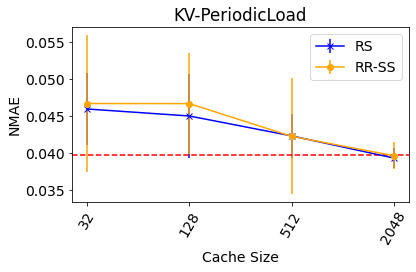

KV-FlashcrowdLoad - Baseline:
        avg    stddev
0  0.036205  0.000108
KV-FlashcrowdLoad - RS:
        avg    stddev
0  0.036662  0.002009
1  0.038838  0.001365
2  0.037237  0.002556
3  0.036692  0.000715
KV-FlashcrowdLoad - RRSS:
        avg    stddev
0  0.034376  0.013709
1  0.041249  0.009589
2  0.037603  0.003478
3  0.036417  0.001380


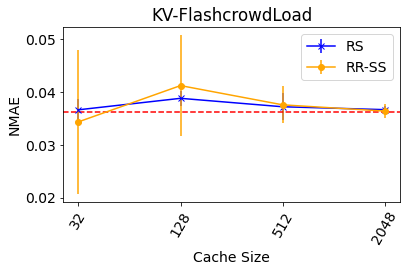

In [7]:
# Project II
# Task II - Online learning on a small-size training set
# KV - Final Results

# Basic Definitions
font = {'size'   : 14}
plt.rc('font', **font)
outdir = "~/Documentos/kth/project/results/"
savedir = "/home/rodolfo/Documentos/kth/project/results/"
cacheSizeList = [32, 128, 512, 2048]
dsList = ["KV-PeriodicLoad", "KV-FlashcrowdLoad"]

for ds in dsList:

    dfBaseline = pd.read_csv(outdir + "p2t1-baseline-stats-" + ds + ".csv", index_col=None, 
                             usecols = ["avg", "stddev"], header=0)    
    print(ds + " - Baseline:")
    print(dfBaseline)

    dfRS = pd.read_csv(outdir + "p2t2-rs-stats-" + ds + ".csv", index_col=None, 
                            usecols = ["avg", "stddev"], header=0)   
    print(ds + " - RS:")
    print(dfRS)

    dfRRSS = pd.read_csv(outdir + "p2t2-rrss-stats-" + ds + ".csv", index_col=None, 
                         usecols = ["avg", "stddev"], header=0)    
    print(ds + " - RRSS:")
    print(dfRRSS)

    #plt.suptitle("Prediction Error (NMAE)")
    plt.title(ds)
    
    #plt.ylim((0.03, 0.05))
    #plt.yticks([0.03, 0.035, 0.04, 0.045, 0.05], [0.03, 0.035, 0.04, 0.045, 0.05])

    x  = np.array(cacheSizeList)

    yBaseline = np.array(dfBaseline["avg"])
    yRS = np.array(dfRS["avg"])
    yRRSS = np.array(dfRRSS["avg"])

    errorBaseline = np.array(dfBaseline["stddev"])
    errorRS = np.array(dfRS["stddev"])
    errorRRSS = np.array(dfRRSS["stddev"])

    #plt.fill_between(x, yRS - errorRS, yRS + errorRS, alpha=0.4, color = "blue")
    #plt.fill_between(x, yRRFS - errorRRFS, yRRFS + errorRRFS, alpha=0.4, color = "orange")

    plt.errorbar(x, yRS, yerr=errorRS, marker='x', label='RS', color = "blue")
    plt.errorbar(x, yRRSS, yerr=errorRRSS, marker='o', label='RR-SS', color = "orange")
    plt.axhline(yBaseline, linestyle ="--", color = "red")

    #plt.plot(x, yRS, marker='x', label='RS', color = "blue")
    #plt.plot(x, yRRFS, marker='o', label='RR-SS', color = "orange")

    plt.xlabel("Cache Size")
    plt.xscale('log', basex=2)
    plt.xticks(x, x, rotation=60)

    plt.ylabel("NMAE")
    plt.legend(loc='best')
    #plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
    plt.tight_layout()
    filename = "results/p2t2-" + ds + ".png"
    #print(filename)
    plt.savefig(filename)
    plt.show()
    plt.close()


In [4]:
# Project II
# Task III - Online learning with model re-computation
# KV - RS

# Basic Definitions
dsList = ["KV-PeriodicLoad", "KV-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "ReadsAvg"
cacheSizeList = [32, 128, 512, 2048]
initSize = 1000
trainSize = 100
testSize = 1000
iterations = 100

# Main
for ds in dsList:
    print("Dataset: " + ds)

    #Read X, Y raw files
    xRaw = pd.read_csv(dir + ds + "/XSelected.csv", index_col=0, header=0)
    #print("xRaw:")
    #print(xRaw)

    yRaw = pd.read_csv(dir + ds + "/YLimited.csv", usecols = [target])
    #print("yRaw:")
    #print(yRaw) 

    # Total size of the dataset
    dsSize = len(xRaw.index)
    #print("Total Size of the Dataset: " + str(dsSize))

    results = pd.DataFrame(columns=['cachesize', 'iteration', 'nmae'])

    for iter in range(1, iterations+1):
        print("Iteration: " + str(iter))

        # Build a RF regressor and Fit the model 
        regr = RandomForestRegressor(max_depth=10, n_estimators=30, n_jobs=4, random_state=13)
        #print ("Build Model Ok!")

        for cacheSize in cacheSizeList:
            print("Cache Size: " + str(cacheSize))

            init = rd.randint(0, dsSize//2)
            #print("Starting Point: " + str(init))

            # Define (X,Y) cache of size cacheSize
            cacheX = xRaw.iloc[init:(init+cacheSize), 0:]
            #print("cacheX:")
            #print(len(cacheX.index))
            
            cacheY = yRaw.iloc[init:(init+cacheSize), 0:2]
            #print("cacheY:")
            #print(cacheY)

            # Rebuild indexes
            cacheX = cacheX.reset_index(drop=True)
            cacheY = cacheY.reset_index(drop=True)
            #print("cacheX:")
            #print(cacheX)

            #print("Initial Training Index - 1st Round: " + str(init + cacheSize))

            for index in range(init+cacheSize, init+cacheSize+initSize):
                #print(index-init+1)
                irs = rd.randint(0, index-init)

                sampleX = xRaw.iloc[index:(index + 1), 0:]
                sampleY = yRaw.iloc[index:(index + 1), 0:2]
                #print("sampleX #" + str(index))
                #print(sampleX)

                if (irs < cacheSize):
                    #print("Sample#" + str(index) + ": Insert")

                    cacheX = cacheX.drop([irs])
                    cacheY = cacheY.drop([irs])

                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)

                    # Insert the new sample in the cache      
                    cacheX = pd.concat([sampleX, cacheX], ignore_index=True, sort=True)
                    cacheY = pd.concat([sampleY, cacheY], ignore_index=True, sort=True)
                            
                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)
            
            # Build the Model
            regr.fit(cacheX, cacheY)

            index = index + 1
            #print("Initial Test Index - 1st Round: " + str(index))
            
            # Defining (X,Y) test dataset for next predictions
            testX = xRaw.iloc[index:index + testSize, 0:]
            testY = yRaw.iloc[index:index + testSize, 0:2]
            #print("testX:")
            #print(testX)
            #print("testY:")
            #print(testY)

            # Do Predictions
            predictedY = regr.predict(testX)

            #print("predictedY:")
            #print(predictedY)
            #print("testY:")
            #print(testY.values.ravel())

            # Calculate NMAE
            nmae  = (abs(predictedY - testY.values.ravel()).mean())/(testY.values.ravel().mean())
            #print("NMAE: " + str(nmae))

            nr = results.append({'cachesize': cacheSize, 'iteration': iter, 'nmae': nmae},  
                                    ignore_index=True)
            results = pd.concat([nr])

            init = index + testSize
            
            #print("Final Test Index - 1st Round: " + str(init))

            #print("Initial Training Index - 2nd Round: " + str(init))

            for index in range(init, init+trainSize):
                #print(index-init+1)
                irs = rd.randint(0, index-init)

                sampleX = xRaw.iloc[index:(index + 1), 0:]
                sampleY = yRaw.iloc[index:(index + 1), 0:2]
                #print("sampleX #" + str(index))
                #print(sampleX)

                if (irs < cacheSize):
                    #print("Sample#" + str(index) + ": Insert")

                    cacheX = cacheX.drop([irs])
                    cacheY = cacheY.drop([irs])

                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)

                    # Insert the new sample in the cache      
                    cacheX = pd.concat([sampleX, cacheX], ignore_index=True, sort=True)
                    cacheY = pd.concat([sampleY, cacheY], ignore_index=True, sort=True)
                            
                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)
             
            # Build the Model
            regr.fit(cacheX, cacheY)

            index = index + 1
            #print("Initial Test Index - 2nd Round: " + str(index))
            
            # Defining (X,Y) test dataset for next predictions
            testX = xRaw.iloc[index:index + testSize, 0:]
            testY = yRaw.iloc[index:index + testSize, 0:2]
            #print("testX:")
            #print(testX)
            #print("testY:")
            #print(testY)

            # Do Predictions
            predictedY = regr.predict(testX)

            #print("predictedY:")
            #print(predictedY)
            #print("testY:")
            #print(testY.values.ravel())

            # Calculate NMAE
            nmae  = (abs(predictedY - testY.values.ravel()).mean())/(testY.values.ravel().mean())
            #print("NMAE: " + str(nmae))

            nr = results.append({'cachesize': cacheSize, 'iteration': iter, 'nmae': nmae},  
                                    ignore_index=True)
            results = pd.concat([nr])

    print(results)
    results.to_csv(outdir + "p2t3-rs-" + ds + ".csv")


Dataset: KV-PeriodicLoad
Iteration: 1
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 2
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 3
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 4
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 5
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 6
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 7
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 8
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 9
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 10
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 11
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 12
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 13
Cache Size: 32
Cache Size: 128
Cac

In [5]:
# Project II
# Task III - Online learning with model re-computation
# KV - RRSS

# Basic Definitions
dsList = ["KV-PeriodicLoad", "KV-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "ReadsAvg"
cacheSizeList = [32, 128, 512, 2048]
initSize = 1000
trainSize = 100
testSize = 1000
iterations = 100

# Main
for ds in dsList:
    print("Dataset: " + ds)

    #Read X, Y raw files
    xRaw = pd.read_csv(dir + ds + "/XSelected.csv", index_col=0, header=0)
    #print("xRaw:")
    #print(xRaw)

    yRaw = pd.read_csv(dir + ds + "/YLimited.csv", usecols = [target])
    #print("yRaw:")
    #print(yRaw) 

    # Total size of the dataset
    dsSize = len(xRaw.index)
    #print("Total Size of the Dataset: " + str(dsSize))

    results = pd.DataFrame(columns=['cachesize', 'iteration', 'nmae'])

    for iter in range(1, iterations+1):
        print("Iteration: " + str(iter))

        # Build a RF regressor and Fit the model 
        regr = RandomForestRegressor(max_depth=10, n_estimators=30, n_jobs=4, random_state=13)
        #print ("Build Model Ok!")

        for cacheSize in cacheSizeList:
            print("Cache Size: " + str(cacheSize))

            init = rd.randint(0, dsSize//2)
            #print("Starting Point: " + str(init))

            # Define (X,Y) cache of size cacheSize
            cacheX = xRaw.iloc[init:(init+cacheSize), 0:]
            #print("cacheX:")
            #print(len(cacheX.index))
            
            cacheY = yRaw.iloc[init:(init+cacheSize), 0:2]
            #print("cacheY:")
            #print(cacheY)

            # Rebuild indexes
            cacheX = cacheX.reset_index(drop=True)
            cacheY = cacheY.reset_index(drop=True)
            #print("cacheX:")
            #print(cacheX)

            # Define a sample vector with the average of all columns in the cache
            cacheAvgSample = pd.DataFrame(cacheX.mean()).transpose()
            #print("cacheAvgSample:")
            #print(cacheAvgSample)

            # Define a vector with the redundancy values between all samples in the cache
            # and the sample vector with the average of all columns
            cacheRedundancyValues = cosine_similarity(cacheX, cacheAvgSample)
            #print("cacheRedundancyValues:")
            #print(cacheRedundancyValues)

            # Define a vector with the relevance values between all samples in the cache
            # and the sample vector with the average of all columns
            cacheRelevanceValues = euclidean_distances(cacheX, cacheAvgSample)
            #print("cacheRelevanceValues:")eY.drop([irs])
            #print(cacheRelevanceValues)

            # Define a vector with the rank between all samples in the cache
            # and the sample vector with the average of all columns
            cacheRankValues = cacheRelevanceValues/cacheRedundancyValues
            #print("cacheRankValues:")
            #print(pd.DataFrame(cacheRankValues).sort_values(by=0))

            # Define the mean value of the rank vector
            cacheRankAvg = pd.DataFrame(cacheRankValues).mean()
            #print("cacheRankMean:")
            #print(cacheRankMean[0])

            #print("Initial Training Index - 1st Round: " + str(init + cacheSize))

            for index in range(init+cacheSize, init+cacheSize+initSize):

                sampleX = xRaw.iloc[index:(index + 1), 0:]
                sampleY = yRaw.iloc[index:(index + 1), 0:2]
                #print("sampleX #" + str(index))
                #print(sampleX)

                sampleRedundancy = cosine_similarity(cacheAvgSample, sampleX)
                #print(sampleRedundancy)eY.drop([irs])

                sampleRelevance = euclidean_distances(cacheAvgSample, sampleX)
                #print(sampleRelevance)

                sampleRank = sampleRelevance/sampleRedundancy
                #print("sampleRank)

                if (sampleRank[0][0] > cacheRankAvg[0]):
                #print("Sample#" + str(index) + ": Insert")

                    # Find the index of the sample with the minimum rank in the cache
                    idxMinCache = pd.DataFrame(cacheRankValues).idxmin().values[0]
                    #print(idxMinCache)

                    # Remove idxMinCache sample from the cache
                    #print(cacheX.iloc[idxMinCache])
                    cacheX = cacheX.drop([idxMinCache])
                    cacheY = cacheY.drop([idxMinCache])

                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)

                    # Insert the new sample in the cache      
                    cacheX = pd.concat([sampleX, cacheX], ignore_index=True, sort=True)
                    cacheY = pd.concat([sampleY, cacheY], ignore_index=True, sort=True)
                            
                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)
            
                    # Update the sample vector with the average of all columns in the cache
                    cacheAvgSample = pd.DataFrame(cacheX.mean()).transpose()
                    #print(cacheAvgSample)

                    # Update the vector with the redundancy values between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRedundancyValues = cosine_similarity(cacheX, cacheAvgSample)
                    #print(cacheRedundancyValues)

                    # Update the vector with the relevance values between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRelevanceValues = euclidean_distances(cacheX, cacheAvgSample)
                    #print(cacheRelevanceValues)

                    # Update the vector with the rank between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRankValues = cacheRelevanceValues/cacheRedundancyValues
                    #print(cacheRankValues)
                    #print(pd.DataFrame(cacheRankValues).sort_values(by=0))

                    # Update the average value of the rank vector
                    cacheRankAvg = pd.DataFrame(cacheRankValues).mean()
                    #print(cacheRankMedian)

            # Build the Model
            regr.fit(cacheX, cacheY)

            index = index + 1
            #print("Initial Test Index - 1st Round: " + str(index))
            
            # Defining (X,Y) test dataset for next predictions
            testX = xRaw.iloc[index:index + testSize, 0:]
            testY = yRaw.iloc[index:index + testSize, 0:2]
            #print("testX:")
            #print(testX)
            #print("testY:")
            #print(testY)

            # Do Predictions
            predictedY = regr.predict(testX)

            #print("predictedY:")
            #print(predictedY)
            #print("testY:")
            #print(testY.values.ravel())

            # Calculate NMAE
            nmae  = (abs(predictedY - testY.values.ravel()).mean())/(testY.values.ravel().mean())
            #print("NMAE: " + str(nmae))

            nr = results.append({'cachesize': cacheSize, 'iteration': iter, 'nmae': nmae},  
                                    ignore_index=True)
            results = pd.concat([nr])

            init = index + testSize
            
            #print("Final Test Index - 1st Round: " + str(init))

            #print("Initial Training Index - 2nd Round: " + str(init))

            for index in range(init, init+trainSize):

                sampleX = xRaw.iloc[index:(index + 1), 0:]
                sampleY = yRaw.iloc[index:(index + 1), 0:2]
                #print("sampleX #" + str(index))
                #print(sampleX)

                sampleRedundancy = cosine_similarity(cacheAvgSample, sampleX)
                #print(sampleRedundancy)eY.drop([irs])

                sampleRelevance = euclidean_distances(cacheAvgSample, sampleX)
                #print(sampleRelevance)

                sampleRank = sampleRelevance/sampleRedundancy
                #print("sampleRank)

                if (sampleRank[0][0] > cacheRankAvg[0]):
                #print("Sample#" + str(index) + ": Insert")

                    # Find the index of the sample with the minimum rank in the cache
                    idxMinCache = pd.DataFrame(cacheRankValues).idxmin().values[0]
                    #print(idxMinCache)

                    # Remove idxMinCache sample from the cache
                    #print(cacheX.iloc[idxMinCache])
                    cacheX = cacheX.drop([idxMinCache])
                    cacheY = cacheY.drop([idxMinCache])

                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)

                    # Insert the new sample in the cache      
                    cacheX = pd.concat([sampleX, cacheX], ignore_index=True, sort=True)
                    cacheY = pd.concat([sampleY, cacheY], ignore_index=True, sort=True)
                            
                    # Rebuild indexes
                    cacheX = cacheX.reset_index(drop=True)
                    cacheY = cacheY.reset_index(drop=True)
             
                    # Update the sample vector with the average of all columns in the cache
                    cacheAvgSample = pd.DataFrame(cacheX.mean()).transpose()
                    #print(cacheAvgSample)

                    # Update the vector with the redundancy values between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRedundancyValues = cosine_similarity(cacheX, cacheAvgSample)
                    #print(cacheRedundancyValues)

                    # Update the vector with the relevance values between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRelevanceValues = euclidean_distances(cacheX, cacheAvgSample)
                    #print(cacheRelevanceValues)

                    # Update the vector with the rank between all samples in the cache
                    # and the sample vector with the average of all columns
                    cacheRankValues = cacheRelevanceValues/cacheRedundancyValues
                    #print(cacheRankValues)
                    #print(pd.DataFrame(cacheRankValues).sort_values(by=0))

                    # Update the average value of the rank vector
                    cacheRankAvg = pd.DataFrame(cacheRankValues).mean()
                    #print(cacheRankMedian)

            # Build the Model
            regr.fit(cacheX, cacheY)

            index = index + 1
            #print("Initial Test Index - 2nd Round: " + str(index))
            
            # Defining (X,Y) test dataset for next predictions
            testX = xRaw.iloc[index:index + testSize, 0:]
            testY = yRaw.iloc[index:index + testSize, 0:2]
            #print("testX:")
            #print(testX)
            #print("testY:")
            #print(testY)

            # Do Predictions
            predictedY = regr.predict(testX)

            #print("predictedY:")
            #print(predictedY)
            #print("testY:")
            #print(testY.values.ravel())

            # Calculate NMAE
            nmae  = (abs(predictedY - testY.values.ravel()).mean())/(testY.values.ravel().mean())
            #print("NMAE: " + str(nmae))

            nr = results.append({'cachesize': cacheSize, 'iteration': iter, 'nmae': nmae},  
                                    ignore_index=True)
            results = pd.concat([nr])

    print(results)
    results.to_csv(outdir + "p2t3-rrss-" + ds + ".csv")


Dataset: KV-PeriodicLoad
Iteration: 1
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 2
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 3
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 4
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 5
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 6
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 7
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 8
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 9
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 10
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 11
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 12
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
Iteration: 13
Cache Size: 32
Cache Size: 128
Cac

In [6]:
# Project II
# Task III - Online learning with model re-computation
# KV - Statistics 

# Basic Definitions
dsList = ["KV-PeriodicLoad", "KV-FlashcrowdLoad"]
dir = "~/Documentos/kth/project/datasets/"
outdir = "~/Documentos/kth/project/results/"
target = "ReadsAvg"
cacheSizeList = [32, 128, 512, 2048]

for ds in dsList:
    print("Dataset: " + ds)

    results = pd.read_csv(outdir + "p2t3-rs-" + ds + ".csv", index_col=0)
    print(results)

    graphResults = pd.DataFrame(columns=['cachesize', 'avg', 'stddev'])

    for cacheSize in cacheSizeList:
        print("Cache Size: " + str(cacheSize))

        cacheResults = results[results['cachesize']==cacheSize]
        #print(cacheResults)

        nr = graphResults.append({'cachesize': cacheSize, 'avg': cacheResults['nmae'].mean(), 
                                  'stddev': cacheResults['nmae'].std()}, ignore_index=True)
        graphResults = pd.concat([nr])
    
    print(graphResults)
    graphResults.to_csv(outdir + "p2t3-rs-stats-" + ds + ".csv")

for ds in dsList:
    print("Dataset: " + ds)

    results = pd.read_csv(outdir + "p2t3-rrss-" + ds + ".csv", index_col=0)
    print(results)

    graphResults = pd.DataFrame(columns=['cachesize', 'avg', 'stddev'])

    for cacheSize in cacheSizeList:
        print("Cache Size: " + str(cacheSize))

        cacheResults = results[results['cachesize']==cacheSize]
        #print(cacheResults)

        nr = graphResults.append({'cachesize': cacheSize, 'avg': cacheResults['nmae'].mean(), 
                                  'stddev': cacheResults['nmae'].std()}, ignore_index=True)
        graphResults = pd.concat([nr])
    
    print(graphResults)
    graphResults.to_csv(outdir + "p2t3-rrss-stats-" + ds + ".csv")


Dataset: KV-PeriodicLoad
     cachesize  iteration      nmae
0         32.0        1.0  0.048283
1         32.0        1.0  0.046020
2        128.0        1.0  0.043182
3        128.0        1.0  0.041781
4        512.0        1.0  0.053510
..         ...        ...       ...
795      128.0      100.0  0.039785
796      512.0      100.0  0.041678
797      512.0      100.0  0.038128
798     2048.0      100.0  0.037292
799     2048.0      100.0  0.033963

[800 rows x 3 columns]
Cache Size: 32
Cache Size: 128
Cache Size: 512
Cache Size: 2048
   cachesize       avg    stddev
0       32.0  0.047832  0.017272
1      128.0  0.043078  0.016201
2      512.0  0.041754  0.012251
3     2048.0  0.038737  0.006048
Dataset: KV-FlashcrowdLoad
     cachesize  iteration      nmae
0         32.0        1.0  0.038368
1         32.0        1.0  0.050548
2        128.0        1.0  0.036693
3        128.0        1.0  0.040011
4        512.0        1.0  0.036121
..         ...        ...       ...
795      12

KV-PeriodicLoad - Baseline:
        avg    stddev
0  0.039744  0.000108
KV-PeriodicLoad - RS:
        avg    stddev
0  0.047832  0.017272
1  0.043078  0.016201
2  0.041754  0.012251
3  0.038737  0.006048
KV-PeriodicLoad - RRSS:
        avg    stddev
0  0.045256  0.024800
1  0.045567  0.021114
2  0.042005  0.016649
3  0.038094  0.007728


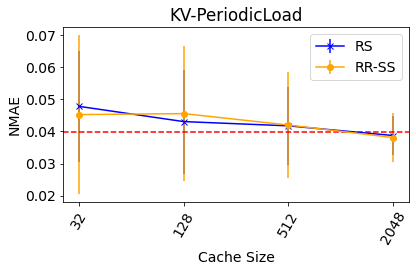

KV-FlashcrowdLoad - Baseline:
        avg    stddev
0  0.036205  0.000108
KV-FlashcrowdLoad - RS:
        avg    stddev
0  0.037677  0.008115
1  0.036945  0.004479
2  0.035882  0.003123
3  0.035569  0.002861
KV-FlashcrowdLoad - RRSS:
        avg    stddev
0  0.037304  0.012153
1  0.038855  0.009611
2  0.036197  0.005840
3  0.035611  0.003302


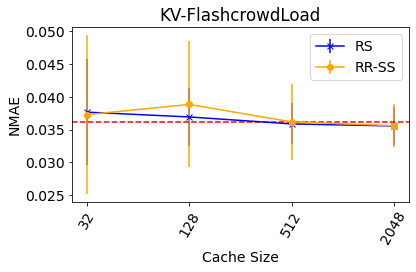

In [8]:
# Project II
# Task III - Online learning with model re-computation
# KV - Final Results

# Basic Definitions
font = {'size'   : 14}
plt.rc('font', **font)
outdir = "~/Documentos/kth/project/results/"
cacheSizeList = [32, 128, 512, 2048]
dsList = ["KV-PeriodicLoad", "KV-FlashcrowdLoad"]

for ds in dsList:

    dfBaseline = pd.read_csv(outdir + "p2t1-baseline-stats-" + ds + ".csv", index_col=None, 
                             usecols = ["avg", "stddev"], header=0)    
    print(ds + " - Baseline:")
    print(dfBaseline)

    dfRS = pd.read_csv(outdir + "p2t3-rs-stats-" + ds + ".csv", index_col=None, 
                            usecols = ["avg", "stddev"], header=0)   
    print(ds + " - RS:")
    print(dfRS)

    dfRRSS = pd.read_csv(outdir + "p2t3-rrss-stats-" + ds + ".csv", index_col=None, 
                         usecols = ["avg", "stddev"], header=0)    
    print(ds + " - RRSS:")
    print(dfRRSS)

    #plt.suptitle("Prediction Error (NMAE)")
    plt.title(ds)
    
    #plt.ylim((0.03, 0.05))
    #plt.yticks([0.03, 0.035, 0.04, 0.045, 0.05], [0.03, 0.035, 0.04, 0.045, 0.05])

    x  = np.array(cacheSizeList)

    yBaseline = np.array(dfBaseline["avg"])
    yRS = np.array(dfRS["avg"])
    yRRSS = np.array(dfRRSS["avg"])

    errorBaseline = np.array(dfBaseline["stddev"])
    errorRS = np.array(dfRS["stddev"])
    errorRRSS = np.array(dfRRSS["stddev"])

    #plt.fill_between(x, yRS - errorRS, yRS + errorRS, alpha=0.4, color = "blue")
    #plt.fill_between(x, yRRFS - errorRRFS, yRRFS + errorRRFS, alpha=0.4, color = "orange")

    plt.errorbar(x, yRS, yerr=errorRS, marker='x', label='RS', color = "blue")
    plt.errorbar(x, yRRSS, yerr=errorRRSS, marker='o', label='RR-SS', color = "orange")
    plt.axhline(yBaseline, linestyle ="--", color = "red")

    #plt.plot(x, yRS, marker='x', label='RS', color = "blue")
    #plt.plot(x, yRRFS, marker='o', label='RR-SS', color = "orange")

    plt.xlabel("Cache Size")
    plt.xscale('log', basex=2)
    plt.xticks(x, x, rotation=60)

    plt.ylabel("NMAE")
    plt.legend(loc='best')
    #plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
    plt.tight_layout()
    filename = "results/p2t3-" + ds + ".png"
    #print(filename)
    plt.savefig(filename)
    plt.show()
    plt.close()
